In [1]:
%matplotlib inline
import os

import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def stdplot(X):
    plt.figure(figsize=(20, 10))
    for i in X:
        plt.plot(i.index, i)    
    plt.xlabel('day')
    plt.ylabel('count')
    plt.show()

In [2]:
if not os.path.exists('data/transactions.csv'):
    if not os.path.exists('data'):
        os.makedirs('data')
    os.system('wget -O data/transactions.csv https://www.dropbox.com/s/3oyrho6agd7clpm/transactions.csv?dl=1')
    
if not os.path.exists('data/tr_mcc_codes.csv'):
    if not os.path.exists('data'):
        os.makedirs('data')
    os.system('wget -O data/tr_mcc_codes.csv https://www.dropbox.com/s/xbzuqm70djim6pk/tr_mcc_codes.csv?dl=1')

In [3]:
transactions = pd.read_csv('data/transactions.csv')

mcc = pd.read_csv('data/tr_mcc_codes.csv', sep=';')

transactions['day'] = transactions.tr_datetime.apply(lambda x: int(x.split(' ')[0]))
transactions = transactions[['day','amount']]

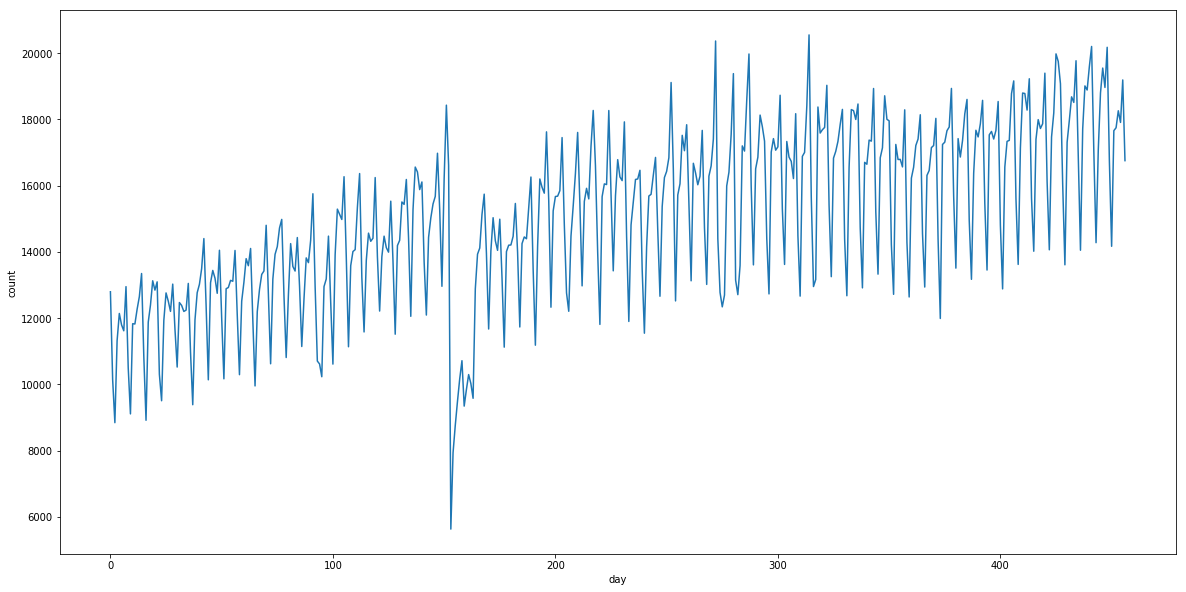

In [4]:
gr = transactions.groupby('day')['amount'].count()

stdplot([gr])

## ARMA
Пригодна для анализа только стационарных рядов, для проверки на стационарность есть [тест Дики-Фулера](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%94%D0%B8%D0%BA%D0%B8_%E2%80%94_%D0%A4%D1%83%D0%BB%D0%BB%D0%B5%D1%80%D0%B0)

# Анализ на стационарность
## Тест Дики — Фуллера

In [5]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
def testadf(X):
    test = sm.tsa.adfuller(X)
    print('adf: ', test[0])
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print('есть единичные корни, ряд не стационарен')
    else:
        print('единичных корней нет, ряд стационарен')

In [6]:
testadf(gr)

adf:  -1.83870113417
p-value:  0.361423882587
Critical values:  {'1%': -3.4452316379305792, '5%': -2.8681012763264233, '10%': -2.5702649212751583}
есть единичные корни, ряд не стационарен


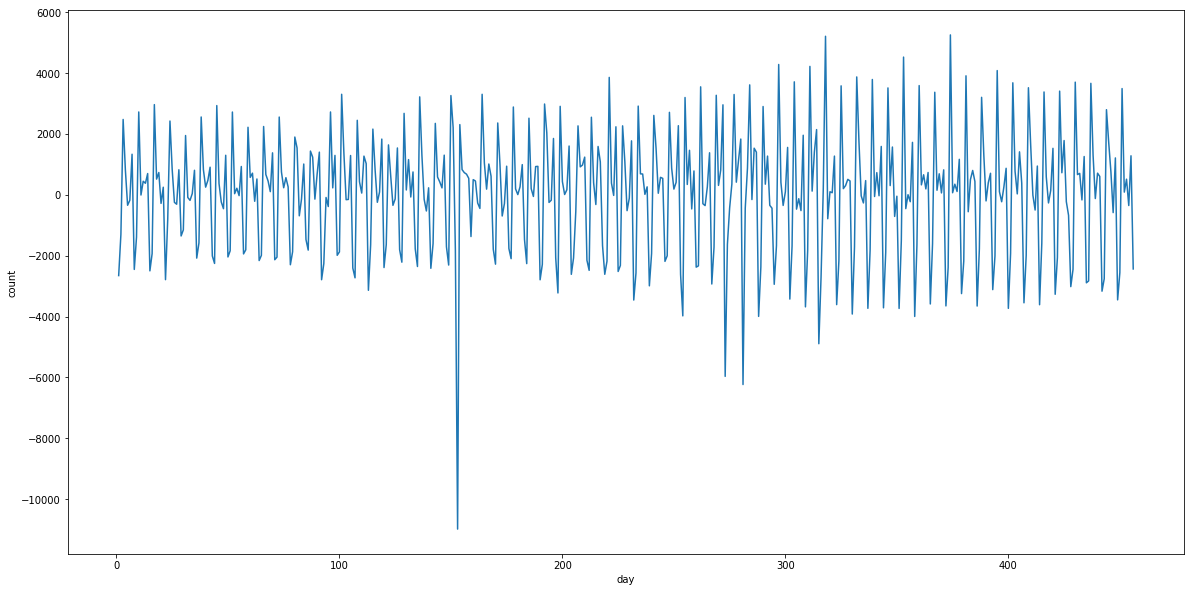

In [7]:
stdplot([gr.diff(periods=1).dropna()])

In [8]:
gr1 = gr.diff(periods=1).dropna()
testadf(gr1)

adf:  -7.74769464269
p-value:  1.02152578052e-11
Critical values:  {'1%': -3.4454029241336483, '5%': -2.8681766097362087, '10%': -2.5703050753263619}
единичных корней нет, ряд стационарен


In [10]:
def f(x):
    stdplot([gr1.rolling(x).mean().fillna(0),gr1])

interact(f, x=widgets.IntSlider(min=2,max=30,step=1,value=2));

interactive(children=(IntSlider(value=2, description='x', max=30, min=2), Output()), _dom_classes=('widget-interact',))

Наш полученный ряд оказался стационарным, можно построить на нем ARMA(p,q)

In [11]:
timegr1 = pd.Series(gr1.values, pd.date_range('1/2/2011', periods=len(gr1), freq='D'))
train_ARMA = timegr1[:-60]
test_ARMA = timegr1[-60:-30]
validate = timegr1[-30:]

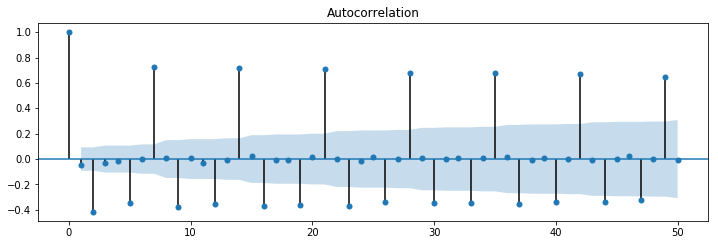

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(gr1.values.squeeze(), lags=50, ax=ax1)

По ACF можно судить о q

q надо брать как номер последнего лага отличного от 0, но так как он лизок к количеству лагов надо взять q достаточно большим

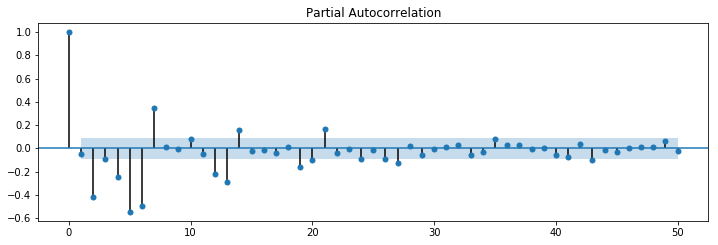

In [13]:
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(gr1, lags=50, ax=ax2)

По PACF можно судить о p

p - примное количество отличных от 0 лагов(не считая первого), их на графике 10

In [ ]:
best_model = (0,0,0)
best_mae = 10**9
for i in range(10):
    for q in range(10):
        try:
            model = ARIMA(train_ARMA, order=(i,0,q))
            model_fit = model.fit(disp=0)
            mae = mean_absolute_error(model_fit.predict(test.index[0], test.index[-1]).cumsum().values,test.cumsum().values)
            if mae < best_mae:
                best_mae = mae
                best_model = (i,0,q)
        except(BaseException):
            pass
print(best_model)

/home/nazar/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/nazar/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/nazar/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/nazar/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/nazar/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to c

/home/nazar/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


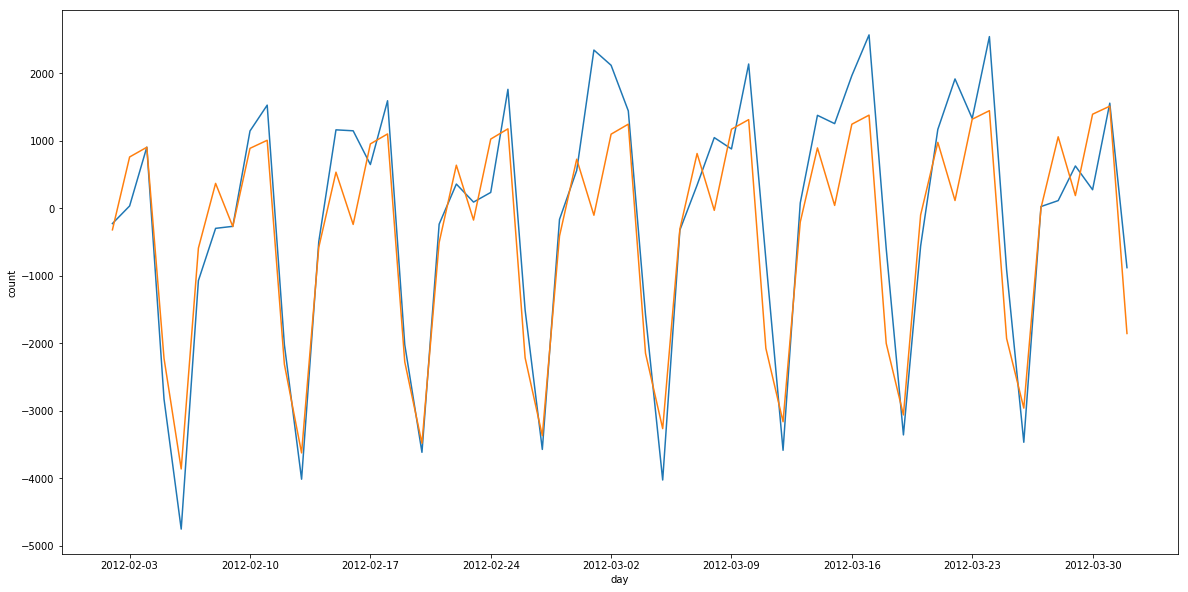

576293.948384


In [13]:
model = ARIMA(train_ARMA, order=(9, 0, 5))
model_fit = model.fit(disp=0)
stdplot([timegr1[-60:].cumsum(), model_fit.predict(timegr1.index[-60], timegr1.index[-1]).cumsum()])
print(mean_squared_error(timegr1[-60:].cumsum().values, model_fit.predict(timegr1.index[-60], timegr1.index[-1]).cumsum().values))

In [14]:
model_fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
====================================================================
Model:              ARMA             BIC:                 6779.1248 
Dependent Variable: y                Log-Likelihood:      -3341.7   
Date:               2017-11-06 04:04 Scale:               1.0000    
No. Observations:   396              Method:              css-mle   
Df Model:           15               Sample:              01-02-2011
Df Residuals:       381                                   02-01-2012
Converged:          0.0000           S.D. of innovations: 1087.178  
AIC:                6715.4222        HQIC:                6740.659  
---------------------------------------------------------------------
             Coef.   Std.Err.       t        P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const       11.7240       nan           nan     nan      nan      nan
ar.L1.y     -0.2956       nan           nan     nan      nan      nan
ar.L2.y     -1.1448       nan           nan     nan      nan      nan
ar.L3.y     -0.7703    0.0000  -371341.4826  0.0000  -0.7703  -0.7703
ar.L4.y     -0.9495    0.0000  -149515.0650  0.0000  -0.9495  -0.9495
ar.L5.y     -1.0017       nan           nan     nan      nan      nan
ar.L6.y     -0.7230       nan           nan     nan      nan      nan
ar.L7.y     -0.1703       nan           nan     nan      nan      nan
ar.L8.y     -0.3518       nan           nan     nan      nan      nan
ar.L9.y     -0.0030    0.0000     -125.2941  0.0000  -0.0030  -0.0029
ma.L1.y     -0.0973    0.0409       -2.3771  0.0179  -0.1774  -0.0171
ma.L2.y      0.8697    0.0350       24.8842  0.0000   0.8012   0.9382
ma.L3.y      0.1380    0.0531        2.5978  0.0097   0.0339   0.2421
ma.L4.y      0.3990    0.0347       11.5031  0.0000   0.3310   0.4670
ma.L5.y      0.5556    0.0433       12.8430  0.0000   0.4708   0.6404
----------------------------------------------------------------------------
                 Real           Imaginary         Modulus          Frequency
----------------------------------------------------------------------------
AR.1            -1.0628           -0.5288           1.1871           -0.4265
AR.2            -1.0628            0.5288           1.1871            0.4265
AR.3            -0.2234           -0.9747           1.0000           -0.2859
AR.4            -0.2234            0.9747           1.0000            0.2859
AR.5             0.6233           -0.7832           1.0010           -0.1430
AR.6             0.6233            0.7832           1.0010            0.1430
AR.7             0.4284           -1.3556           1.4217           -0.2013
AR.8             0.4284            1.3556           1.4217            0.2013
AR.9          -118.3514           -0.0000         118.3514           -0.5000
MA.1             0.6492           -0.8252           1.0499           -0.1439
MA.2             0.6492            0.8252           1.0499            0.1439
MA.3            -0.2297           -0.9979           1.0240           -0.2860
MA.4            -0.2297            0.9979           1.0240            0.2860
MA.5            -1.5570           -0.0000           1.5570           -0.5000
====================================================================

"""

In [15]:
ARMApred = model_fit.predict(timegr1.index[-60], timegr1.index[-1]).cumsum()[-30:] 
ARMApred = ARMApred - ARMApred[0]

# FacebookProphet

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


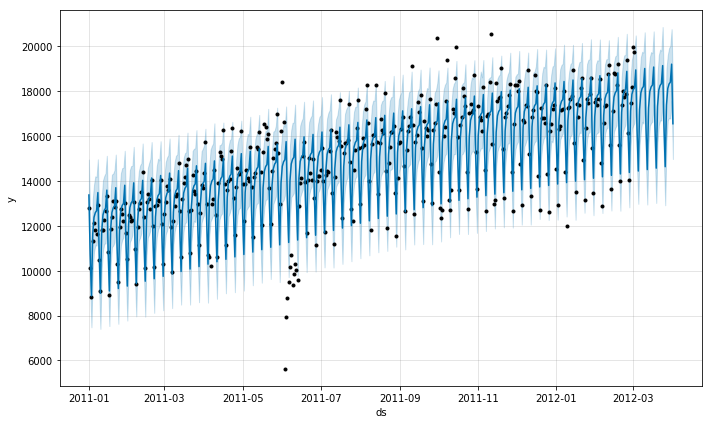

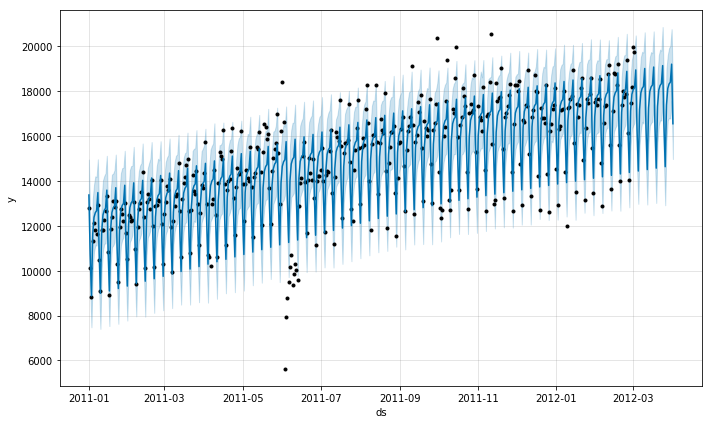

In [16]:
from fbprophet import Prophet

period = pd.date_range('1/1/2011', periods=len(gr), freq='D')
train_fb = pd.DataFrame(data={'ds': period, 'y': gr.values})[:-30]
test_fb = pd.DataFrame(data={'ds': period, 'y': gr.values})[-30:]

fb = Prophet()
fb.fit(train_fb)
future = fb.make_future_dataframe(periods=30)
forecast = fb.predict(future)
fb.plot(forecast)

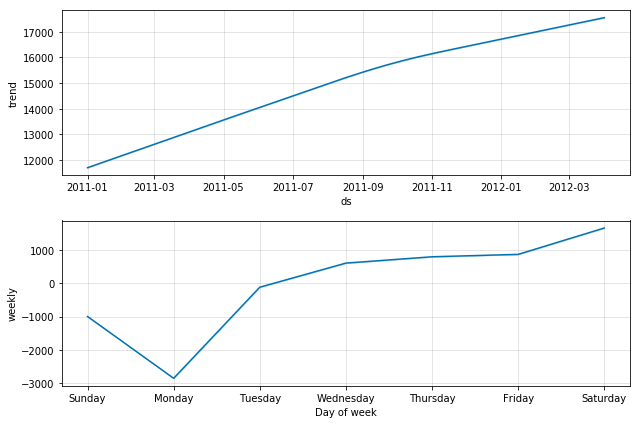

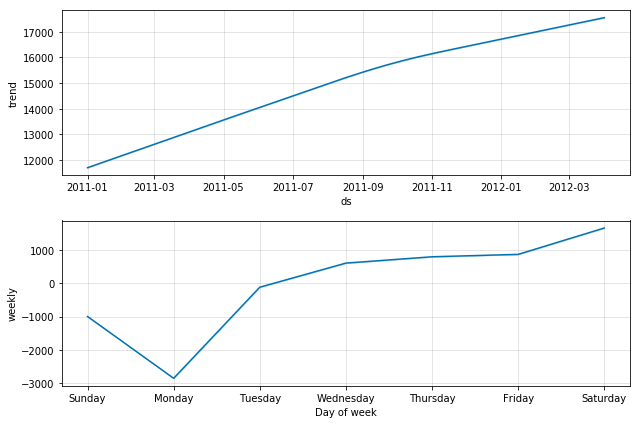

In [17]:
fb.plot_components(forecast)

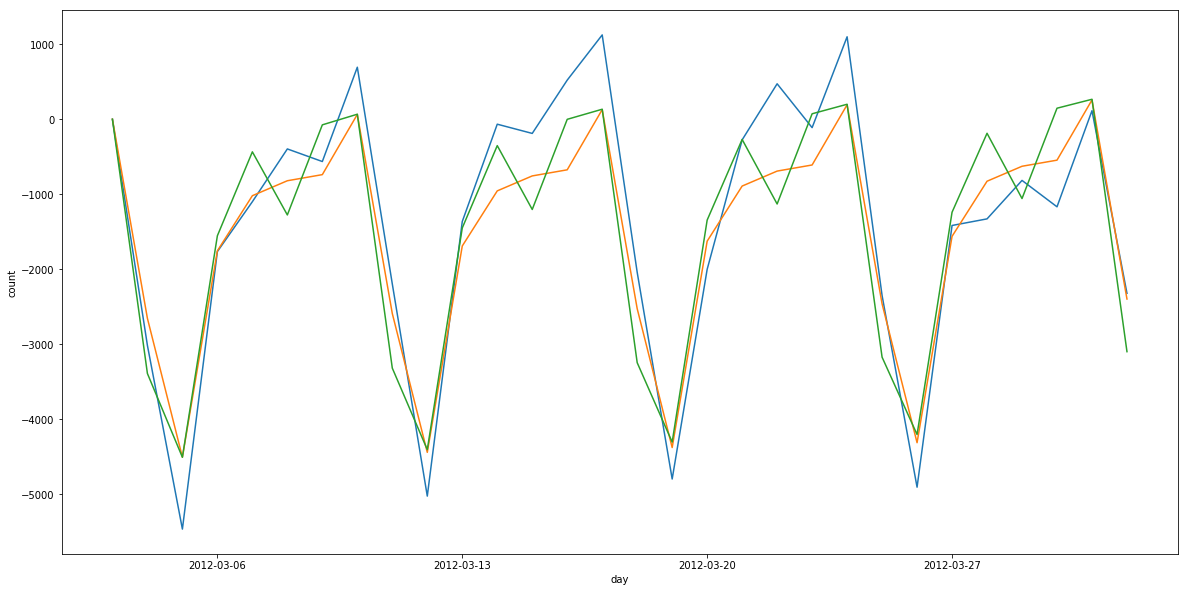

341659.487216


In [18]:
FBpred = pd.Series(forecast.yhat.values, forecast.ds.values)[-30:]
FBpred -= FBpred[0]
Real = pd.Series(test_fb.y.values, test_fb.ds.values)
Real -= Real[0]
stdplot([Real, FBpred, ARMApred])
print(mean_squared_error(Real.values, FBpred.values))